In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter

try:
    df = pd.read_csv('/content/data.csv')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: 'data.csv' not found. Please upload the file.")

if 'id' in df.columns:
    df = df.drop('id', axis=1)
if 'Unnamed: 32' in df.columns:
    df = df.drop('Unnamed: 32', axis=1)

df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

X = df.drop('diagnosis', axis=1).values
y = df['diagnosis'].values

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

print(f"Training Data Shape: {X_train.shape}")
print(f"Testing Data Shape: {X_test.shape}")

Dataset loaded successfully.
Training Data Shape: (455, 30)
Testing Data Shape: (114, 30)


In [ ]:
class KNN_Scratch:
    def __init__(self, k=3, metric='euclidean', p=3):
        self.k = k
        self.metric = metric
        self.p = p

    def fit(self, X_train, y_train):
        self.X_train = X_train
        self.y_train = y_train

    def _calculate_distance(self, x1, x2):
        if self.metric == 'euclidean':
            return np.sqrt(np.sum((x1 - x2)**2))

        elif self.metric == 'manhattan':
            return np.sum(np.abs(x1 - x2))

        elif self.metric == 'minkowski':
            return np.power(np.sum(np.power(np.abs(x1 - x2), self.p)), 1/self.p)

        elif self.metric == 'cosine':
            dot_product = np.dot(x1, x2)
            norm_x1 = np.linalg.norm(x1)
            norm_x2 = np.linalg.norm(x2)
            if norm_x1 == 0 or norm_x2 == 0: return 1.0
            return 1 - (dot_product / (norm_x1 * norm_x2))

        elif self.metric == 'hamming':
            return np.mean(np.abs(x1 - x2) > 1e-5)

        else:
            raise ValueError("Unknown metric")

    def predict(self, X_test):
        y_pred = [self._predict_single(x) for x in X_test]
        return np.array(y_pred)

    def _predict_single(self, x):
        distances = [self._calculate_distance(x, x_train) for x_train in self.X_train]

        k_indices = np.argsort(distances)[:self.k]

        k_nearest_labels = [self.y_train[i] for i in k_indices]

        most_common = Counter(k_nearest_labels).most_common(1)
        return most_common[0][0]

def calculate_metrics(y_true, y_pred):
    accuracy = np.mean(y_true == y_pred)

    TP = np.sum((y_true == 1) & (y_pred == 1))
    TN = np.sum((y_true == 0) & (y_pred == 0))
    FP = np.sum((y_true == 0) & (y_pred == 1))
    FN = np.sum((y_true == 1) & (y_pred == 0))

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    return accuracy, precision, recall, [[TN, FP], [FN, TP]]

In [ ]:
k_values = [3, 4, 9, 20, 47]
distance_metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine', 'hamming']

results = []

print("Starting training... (This might take a moment due to 'from scratch' implementation)")

for metric in distance_metrics:
    accuracies = []
    print(f"Testing metric: {metric}...")
    for k in k_values:
        clf = KNN_Scratch(k=k, metric=metric, p=3)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        acc, prec, rec, cm = calculate_metrics(y_test, y_pred)

        results.append({
            'k': k,
            'metric': metric,
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'confusion_matrix': cm
        })
        accuracies.append(acc)

print("Experimentation complete.")

Starting training... (This might take a moment due to 'from scratch' implementation)
Testing metric: euclidean...
Testing metric: manhattan...
Testing metric: minkowski...
Testing metric: cosine...
Testing metric: hamming...
Experimentation complete.


--------------------------------------------------
BEST MODEL RESULTS
--------------------------------------------------
Best K: 9
Best Distance Metric: euclidean
Testing Accuracy: 0.9649
Precision: 0.9535
Recall: 0.9535
Confusion Matrix:


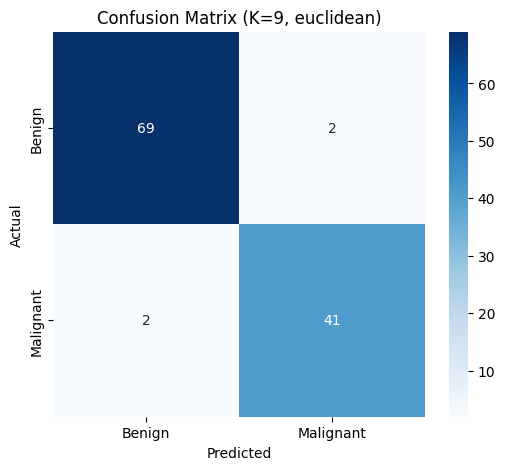

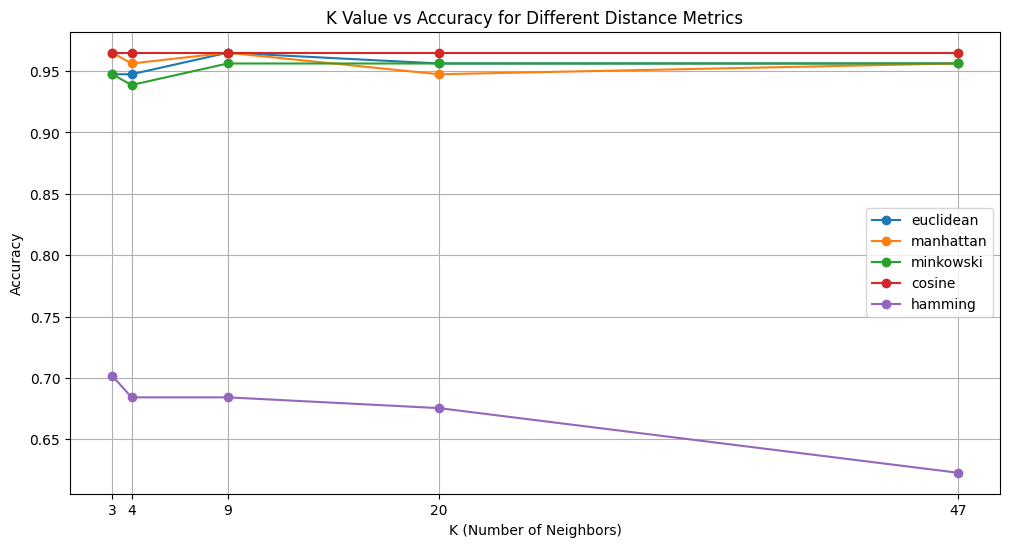

In [ ]:

res_df = pd.DataFrame(results)


best_run = res_df.loc[res_df['accuracy'].idxmax()]

print("-" * 50)
print("BEST MODEL RESULTS")
print("-" * 50)
print(f"Best K: {best_run['k']}")
print(f"Best Distance Metric: {best_run['metric']}")
print(f"Testing Accuracy: {best_run['accuracy']:.4f}")
print(f"Precision: {best_run['precision']:.4f}")
print(f"Recall: {best_run['recall']:.4f}")
print("Confusion Matrix:")
cm = np.array(best_run['confusion_matrix'])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title(f'Confusion Matrix (K={best_run["k"]}, {best_run["metric"]})')
plt.show()

plt.figure(figsize=(12, 6))

for metric in distance_metrics:
    subset = res_df[res_df['metric'] == metric]
    plt.plot(subset['k'], subset['accuracy'], marker='o', label=metric)

plt.title('K Value vs Accuracy for Different Distance Metrics')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.legend()
plt.grid(True)
plt.show()

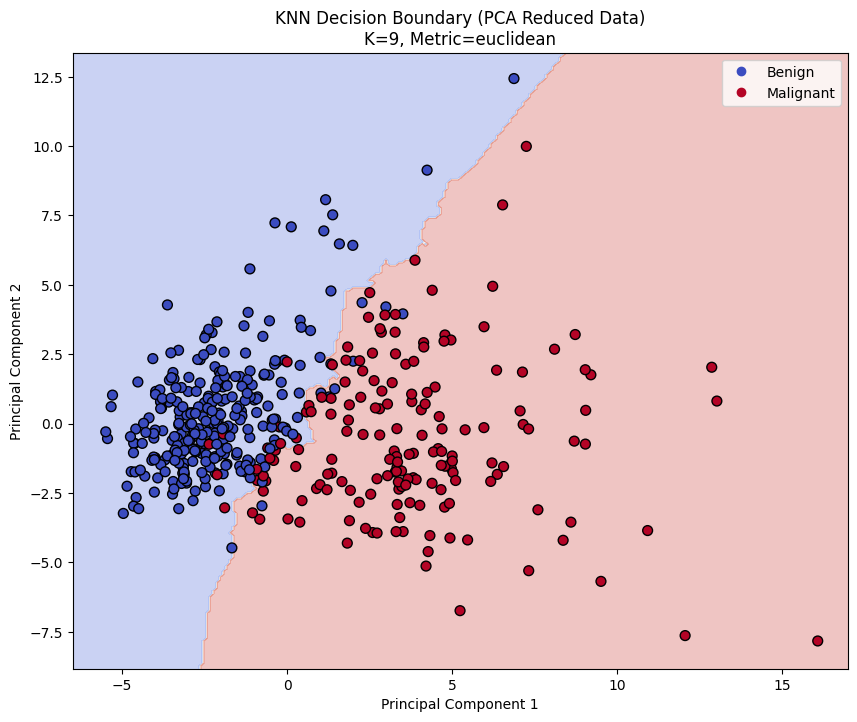

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

best_k = best_run['k']
best_metric = best_run['metric']

clf_viz = KNN_Scratch(k=best_k, metric=best_metric, p=3)
clf_viz.fit(X_train_pca, y_train)

h = 0.1
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

mesh_data = np.c_[xx.ravel(), yy.ravel()]
Z = clf_viz.predict(mesh_data)
Z = Z.reshape(xx.shape)

plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
scatter = plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm', edgecolors='k', s=50)
plt.title(f'KNN Decision Boundary (PCA Reduced Data)\nK={best_k}, Metric={best_metric}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=['Benign', 'Malignant'])
plt.show()